In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Summary

In [2]:
def get_data(logdir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for rundir in os.listdir(logdir):
        if os.path.isdir(os.path.join(logdir, rundir)):
            configfile, datafile, metricfile = [logdir + rundir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            try:
                with open(configfile, "r") as f:
                    cfgs.append(json.load(f))
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"Failed loading one or more files from {rundir}.")
        else:
            with open(logdir + rundir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
#     for c in cfgs_flat:
#         c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
#         c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
#     configs_df.rename(columns={"optimizer_svgd_args": "lr_svgd", "optimizer_ksd_args": "lr_ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["encoder_layers"] = all_df.encoder_layers.astype('str').astype('category')
    all_df["decoder_layers"] = all_df.decoder_layers.astype('str').astype('category')
    all_df.target_args       = all_df.target_args.astype('str').astype("category")
    all_df["train"] = all_df.train.astype('category')
    
    # to numeric
    all_df.lr_ksd  = pd.to_numeric(all_df.lr_ksd.astype("str"), errors="coerce")
    all_df.lr_svgd = pd.to_numeric(all_df.lr_svgd.astype("str"), errors="coerce")
    
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")
#         all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [3]:
ls ../../leonhard-runs/

2-dim/  2-dim-banana/  aug-4/  aug-5/


In [78]:
rundir = basedir + "leonhard-runs/2-dim/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)

KeyboardInterrupt: 

In [173]:
relevant = ["se_mean", "se_var", "ksd", "emd"] + ["lr_ksd", "lr_svgd", "svgd_steps", "encoder_layers", "ksd_steps", "train", "lambda_reg", "target_args", "minimize_ksd_variance"]
f = frame[relevant]
# f

In [174]:
f.emd.describe()

count    182.000000
mean       7.871210
std        3.707217
min        0.000000
25%        3.894908
50%       10.052979
75%       10.871811
max       11.127576
Name: emd, dtype: float64

In [175]:
f.se_mean.describe()

count    181.000000
mean      36.612064
std       25.115726
min        0.006681
25%        4.695167
50%       50.000336
75%       58.088173
max       61.436386
Name: se_mean, dtype: float64

# Hyperparameter comparison

Does minimizing the variance help? (No, no effect).

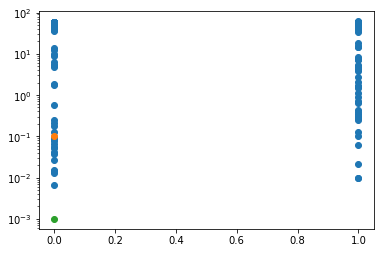

In [160]:
plt.scatter(f.minimize_ksd_variance, f.se_mean)
plt.scatter(0, 0.1)
plt.scatter(0, 0.001)
plt.yscale("log")

## Just vanilla

Clear trend for the SVGD learning rate (which is the only difference between the vanilla runs).

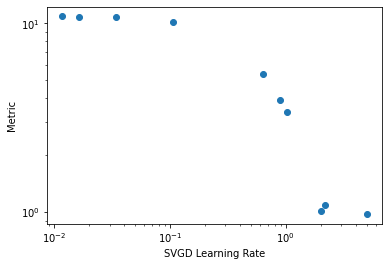

In [168]:
v = frame[f.train == False]
plt.scatter(v.lr_svgd, v.emd)
plt.xlabel("SVGD Learning Rate")
plt.ylabel("Metric")
plt.xscale("log")
plt.yscale("log")

# Vanilla + MLP

## SVGD LR
Again, a clear trend for SVGD learning rate. Not so clear for the layer sizes.

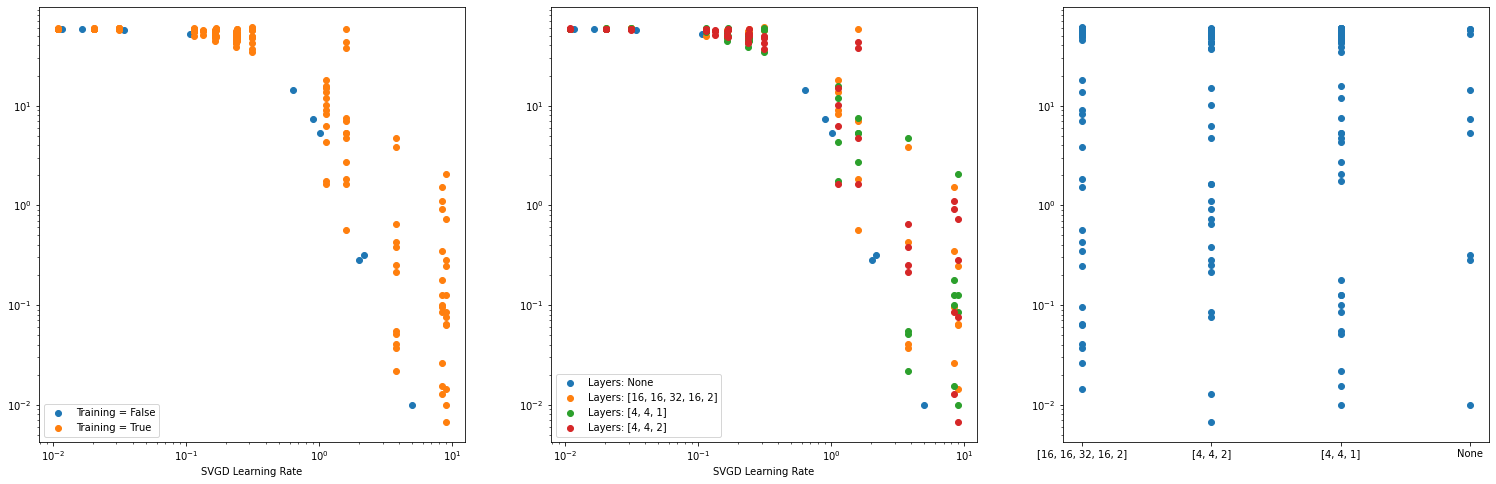

In [119]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
for ax, grouplabel, prefix in zip(axs, ("train", "encoder_layers"), ("Training = ", "Layers: ")):
    groups = f.groupby(grouplabel)
    for name, group in groups:
        ax.scatter(group.lr_svgd, group.se_mean, marker="o", label=prefix + str(name))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    _ = ax.set_xlabel("SVGD Learning Rate")

axs[2].scatter(f.encoder_layers, f.se_mean)
axs[2].set_yscale("log")

# Just MLP

In [176]:
f = f[f.train]

## Lambda
The Autoencoder regularization parameter is important:

Unfortunately, I didn't sample small enough (will fix in next run).

(0.004, 100.0)

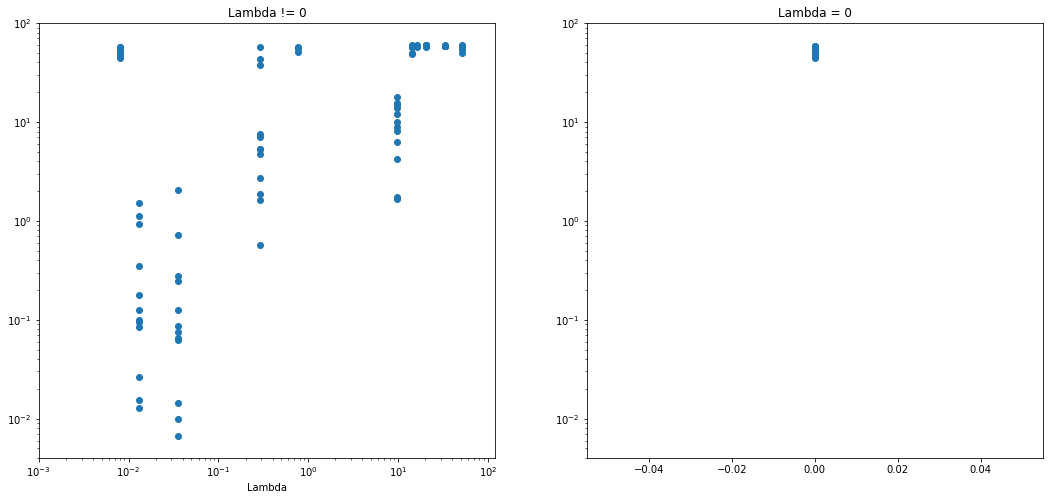

In [177]:
fig, axs = plt.subplots(1, 2, figsize=[18,8])
ax = axs[0]
ax.set_title("Lambda != 0")
ax.scatter(f.lambda_reg, f.se_mean)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.001, 120)
ax.set_ylim(0.004, 100)
ax.set_xlabel("Lambda")

ax = axs[1]
ax.set_title("Lambda = 0")
ax.scatter(f[f.lambda_reg==0].lambda_reg, f[f.lambda_reg==0].se_mean)
ax.set_yscale("log")
ax.set_ylim(axs[0].get_ylim())

For next plots, leave out shitty unregularized results.

In [178]:
f = f[f.lambda_reg != 0]

## KSD Variance

This parameter is irrelevant

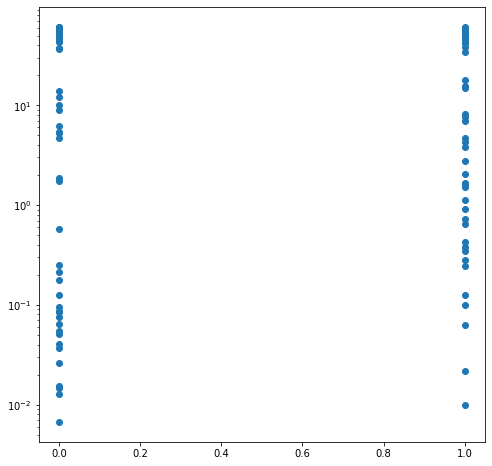

In [179]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(f.minimize_ksd_variance, f.se_mean)
ax.set_yscale("log")

## Encoder / decoder LR

This learning rate is also important. Tho need more data here too.

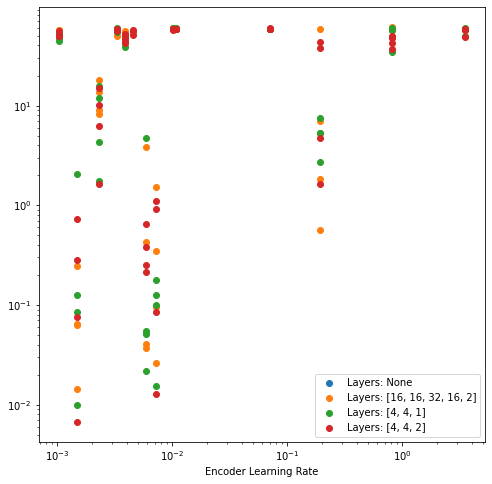

In [181]:
fig, ax = plt.subplots(figsize=[8,8])
groups = f.groupby(grouplabel)
for name, group in groups:
    ax.scatter(group.lr_ksd, group.se_mean, marker="o", label=prefix + str(name))
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
_ = ax.set_xlabel("Encoder Learning Rate")

# Rundata

In [29]:
ind = 2
f.iloc[ind]

se_mean                                                          0.0543464
se_var                                                             2.23572
ksd                                                               0.370215
emd                                                               0.986708
lr_ksd                                                          0.00590994
lr_svgd                                                            3.80501
svgd_steps                                                               1
encoder_layers                                                   [4, 4, 1]
ksd_steps                                                                5
train                                                                 True
lambda_reg                                                     2.85673e-05
target_args              [[6, 3], [[5.758691293044347, 2.73343154077325...
minimize_ksd_variance                                                False
Name: 2, dtype: object

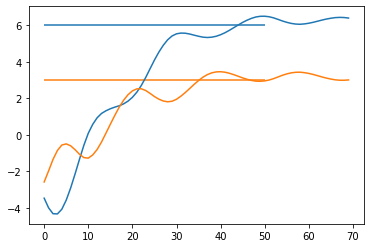

In [30]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean = onp.array(rundata[ind]["training_mean"])
tru_mean = configs[ind]["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 50, colors=colorcycle)

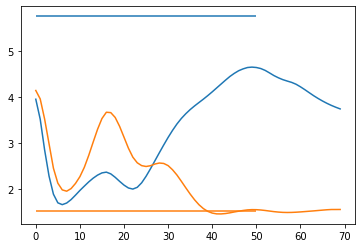

In [31]:
var = onp.array(rundata[ind]["training_var"])
tru_var = onp.diag(configs[ind]["svgd"]["target_args"][1])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 50, colors=colorcycle)